# ECSE 420 - Lab 3
Parallelized convolution, matrix inversion, and matrix multiplication algorithms.

In [0]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba

import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/lib/nvidia-cuda-toolkit/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/lib/x86_64-linux-gnu/libnvvm.so"

In [0]:
from numba import cuda
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

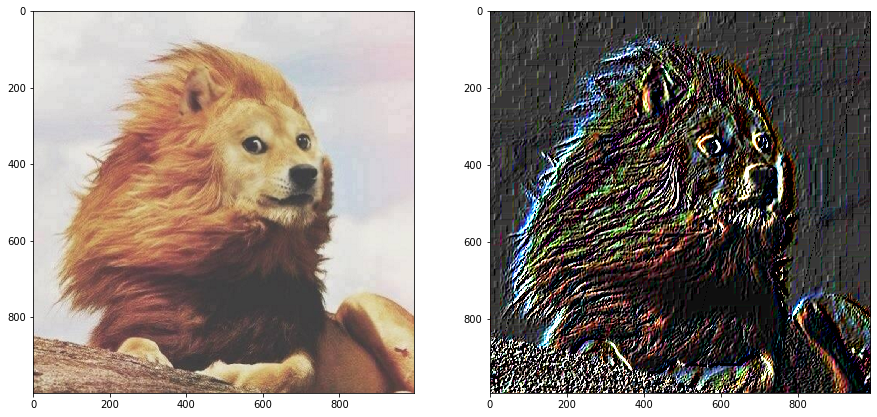

MSE: 1876.041749698499


In [4]:
@cuda.jit
def convolution(originalImg, resultImg, convDim, weightMatrix):
  x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x 
  y = x // len(resultImg[0])
  x %= len(resultImg)

  # perform convolution
  for convX in range(convDim):
    for convY in range(convDim):
      for z in [0, 1, 2]:
        resultImg[x, y, z] += originalImg[x + convX - 1][y + convY - 1][z] * weightMatrix[convX][convY]
      
  # clamp result to [0, 255]
  for z in [0, 1, 2]:
    if resultImg[x, y, z] < 0:
      resultImg[x, y, z] = 0
    elif resultImg[x, y, z] > 255:
      resultImg[x, y, z] = 255

# parameter selection
numBlocks = 978
threadsPerBlock = 1000
convDim = 7

inputFile = '/content/drive/My Drive/Colab Notebooks/ECSE420/test.png'
outputFile = '/content/drive/My Drive/Colab Notebooks/ECSE420/conv' + str(convDim) + 'x' + str(convDim) + '.png'
expectedFile = '/content/drive/My Drive/Colab Notebooks/ECSE420/test_convolve_' + str(convDim) + 'x' + str(convDim) + '.png'

# variable setup
if convDim == 3:
  w = np.asarray([[1, 2, -1], 
                  [2, 0.25, -2], 
                  [1, -2, -1]])
elif convDim == 5:
  w = np.asarray([[0.5,	0.75, 1, -0.75, -0.5],
                  [0.75, 1, 2, -1, -0.75],
                  [1, 2, 0.25, -2, -1],
                  [0.75, 1, -2, -1, -0.75],
                  [0.5, 0.75, -1, -0.75, -0.5]])
elif convDim == 7:
  w = np.asarray([[0.25,	0.3, 	0.5, 	0.75, 	-0.5, 	-0.3, 	-0.25],
                  [0.3,	0.5,	0.75,	1,		-0.75,	-0.5, 	-0.3],
                  [0.5,	0.75,	1,		2,		-1,		-0.75,	-0.5],
                  [0.75,	1,		2,		0.25,	-2,		-1, 	-0.75],
                  [0.5,	0.75,	1,		-2,		-1,		-0.75, 	-0.5],
                  [0.3,	0.5,	0.75,	-1,		-0.75,	-0.5, 	-0.3],
                  [0.25, 	0.3,	0.5,	-0.75,	-0.5, 	-0.3, 	-0.25]])
originalImg = np.float64(cv2.cvtColor(cv2.imread(inputFile), cv2.COLOR_BGR2RGB))
resultImg = np.float64(np.zeros((originalImg.shape[0] - (convDim - 1),
                                 originalImg.shape[1] - (convDim - 1),
                                 originalImg.shape[2])))

# function call (numba performs host -> device -> host memory transfers)
convolution[numBlocks, threadsPerBlock](originalImg, resultImg, convDim , w)

# save results
cv2.imwrite(outputFile, resultImg)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(np.uint8(originalImg))
plt.subplot(122), plt.imshow(np.uint8(resultImg))
plt.show()

# calculate error between result and expected result
expectedResult = cv2.cvtColor(cv2.imread(expectedFile), cv2.COLOR_BGR2RGB)
print("MSE: {}".format(((resultImg - expectedResult)**2).mean(axis=None)))

In [5]:
import time

@cuda.jit
# 2D matrix A multiplied by 1D vector X to produce 1D result
def multiply(A, X, result, length):
  x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  
  if x < length:
    for i in range(length):
      result[x] += A[x][i] * X[i]

# filepath
filepath = "/content/drive/My Drive/Colab Notebooks/ECSE420/npArrays/"

# parameter selection
numBlocks = 1
threadsPerBlock = 1000    # maximum 1024
convDim = 3
size = 1024

for threadsPerBlock in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
  executionTime = 0
  for i in range(1000):  # execute 100 times to get an average
    # variable setup
    A = np.load(filepath + "A" + str(size) + ".npy")
    b = np.load(filepath + "b" + str(size) + ".npy")
    if size == 10:
      X = np.linalg.solve(A, b)
    else:
      X = np.load(filepath + "X" + str(size) + ".npy")

    result = np.zeros((X.shape))

    # function call (numba performs host -> device -> host memory transfers)
    start = time.time()
    multiply[numBlocks, threadsPerBlock](A, X, result, len(result))
    executionTime += time.time() - start

    if np.subtract(result, b).all() != 0:
      # only print if there was a mistake
      print("Multiplication at size {} was NOT successful.".format(size))
  print("Average execution time is {} with {} threads.".format(executionTime / 1000, threadsPerBlock))

Average execution time is 0.0037388970851898193 with 1 threads.
Average execution time is 0.003621307849884033 with 2 threads.
Average execution time is 0.003709245204925537 with 4 threads.
Average execution time is 0.0039433341026306155 with 8 threads.
Average execution time is 0.00398167085647583 with 16 threads.
Average execution time is 0.004462306022644043 with 32 threads.
Average execution time is 0.004445775270462036 with 64 threads.
Average execution time is 0.004504131317138672 with 128 threads.
Average execution time is 0.004646390676498413 with 256 threads.
Average execution time is 0.005466817140579223 with 512 threads.
Average execution time is 0.007453972339630127 with 1024 threads.
